# Receiving weather API data and inserting into JSON Dataset

## This projects use following Libraries:
- requests==2.31.0
- pandas==2.1.4
- geopandas==0.14.1
- DateTime==5.4
- matplotlib==3.8.2
- folium==0.15.1
- mapclassify==2.6.1
- json


In [1]:
import os
import requests
import pandas as pd
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
import json

## Get API key from https://openweathermap.org/ and create API_KEY.txt file in virtual environment

In [2]:
# Calling API_KEY
try:
    with open('.venv/API.txt', 'r') as file:
        API_KEY = file.read().strip()
    print('API Key found.')
    print(API_KEY)
except Exception as e:
    print('API Key not found.')

API Key found.
a3a03b31b2fcfa0091ebdd5bcd9eaabe


## Building code for getting API to JSON

In [3]:
## make code for inputting city
# city = input('Enter a city name: ')
city = 'Jakarta' # Default city is Jakarta

# API calling format to change city and use API KEY
BASE_URL = 'http://api.openweathermap.org/data/2.5/weather'
request_url = f'{BASE_URL}?appid={API_KEY}&q={city}'
print('Calling API')
response = requests.get(request_url)

# to make sure the response is correct
if response.status_code == 200:
    data = response.json()
    print('Data Accepted.')
else:
    print(f'Error {response.status_code}: {response.text}')



Calling API
Data Accepted.


## Cleansing JSON Data

In [4]:
# analyze the response API data
print(data)

{'coord': {'lon': 106.8451, 'lat': -6.2146}, 'weather': [{'id': 501, 'main': 'Rain', 'description': 'moderate rain', 'icon': '10d'}, {'id': 211, 'main': 'Thunderstorm', 'description': 'thunderstorm', 'icon': '11d'}], 'base': 'stations', 'main': {'temp': 305.09, 'feels_like': 312.09, 'temp_min': 304.2, 'temp_max': 307.33, 'pressure': 1006, 'humidity': 85}, 'visibility': 5000, 'wind': {'speed': 2.57, 'deg': 340}, 'rain': {'1h': 0.21}, 'clouds': {'all': 75}, 'dt': 1704870353, 'sys': {'type': 1, 'id': 9383, 'country': 'ID', 'sunrise': 1704840348, 'sunset': 1704885196}, 'timezone': 25200, 'id': 1642911, 'name': 'Jakarta', 'cod': 200}


In [5]:
print('Processing Data.')
# Get Coordinate
Lat = data['coord']['lat']
Long = data['coord']['lon']

# Convert Unix time to Datetime
Date = str(datetime.datetime.fromtimestamp(data['dt']).strftime('%Y-%m-%d %H:%M:%S'))

# Get weather data
City_Name = data['name']
Temp_Avg = round(((data['main']['temp_max']+data['main']['temp_min'])/2)- 273.15,2) # Converting Kelvin to Celsius
Pressure = data['main']['pressure']
Humidity = data['main']['humidity']
Wind_spd = data['wind']['speed']
Wind_deg = data['wind']['deg']
Cloud_Percent = data['clouds']['all']

# Printing output data from API
print(f'''
      It's {Date}
      temperature in {City_Name} is {Temp_Avg}°C
      with {Cloud_Percent}% cloud
      and {Humidity}% Humidity''')

Processing Data.

      It's 2024-01-10 14:05:53
      temperature in Jakarta is 32.62°C
      with 75% cloud
      and 85% Humidity


### Validating the data

In [6]:
# Formating from JSON to Pandas Dataframe
Data_Clean = pd.DataFrame({
    'Date': Date,
    'City': City_Name,
    'Temp_Avg': str(Temp_Avg) + ' Celcius',
    'Pressure': Pressure,
    'Humidity': str(Humidity) + ' %',
    'Wind_spd': Wind_spd,
    'Wind_deg': Wind_deg,
    'Cloud': str(Cloud_Percent) + ' %',
    'Long': Long,
    'Lat': Lat,}
    , index=[0])
print('Done.')

print('After cleansing data from API.')
print(Data_Clean)

Done.
After cleansing data from API.
                  Date     City       Temp_Avg  Pressure Humidity  Wind_spd  \
0  2024-01-10 14:05:53  Jakarta  32.62 Celcius      1006     85 %      2.57   

   Wind_deg Cloud      Long     Lat  
0       340  75 %  106.8451 -6.2146  


### Visualize data from API

In [7]:
# Location
crs = {'init':'epsg:4326'}
geo_data = Data_Clean
Data_Clean['geometry'] = gpd.points_from_xy(Data_Clean['Long'], Data_Clean['Lat'])
geo_data = gpd.GeoDataFrame(Data_Clean, crs=crs, geometry=Data_Clean['geometry'])
geo_data.explore()
# Wind Speed and direction

# Temperature, Pressure, Humidity, and Cloud

c:\Project Coding\Python\JSON-and-XML-weather-API-reciever\.venv\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## inserting to Databases

In [8]:
# Convert the DataFrame to a dictionary and then to JSON
if 'geometry' in Data_Clean.columns:
    Data_Clean = pd.DataFrame(Data_Clean.drop(columns='geometry'))
JSON_Data = Data_Clean.to_dict(orient='records')

# Export JSON data to a file
try:
    file_path = 'datastorage/weatherdata.json'
    # Checking weather data storage
    if os.path.exists(file_path):
        print('Dataset exists. Reading Data.')
        Data_Clean['Date'] = pd.to_datetime(Data_Clean['Date'])
        Data_Existing = pd.read_json(file_path)

        print('Merging data.')
        Data_Merged = pd.concat([Data_Clean,Data_Existing], ignore_index=True)
        Data_Merged = Data_Merged.to_json(orient = 'records')

        with open(file_path, 'w') as JSON_File:
            json.dump(json.loads(Data_Merged), JSON_File)
        print('DataFrame exported to JSON successfully.')

    # if data not available, make a new one
    else:
        print('Dataset not found. Building new dataset.')
        with open(file_path, 'w') as JSON_File:
            json.dump(JSON_Data, JSON_File)
        print('DataFrame exported to JSON successfully.')

# Printing error that occured if existed
except Exception as e:
    print(f'Error: {e}')

Dataset exists. Reading Data.
Merging data.
DataFrame exported to JSON successfully.


## Visualizing time series data from databases

### Load JSON format data and covert into DataFrame

In [9]:
# Load Dataset file
Dataset = pd.read_json(file_path)
print('Dataset found.')
print(Dataset)

Dataset found.
                  Date       City       Temp_Avg  Pressure Humidity  Wind_spd  \
0  2024-01-10 14:05:53    Jakarta  32.62 Celcius      1006     85 %      2.57   
1  2024-01-10 14:00:07    Jakarta  31.98 Celcius      1006     85 %      2.57   
2  2024-01-08 19:23:32    Jakarta  27.33 Celcius      1010     73 %      1.33   
3  2024-01-08 19:23:32    Jakarta  27.33 Celcius      1010     73 %      1.33   
4  2024-01-08 19:13:02    Jakarta  28.09 Celcius      1010     75 %      2.57   
5  2024-01-08 19:13:02    Jakarta  28.09 Celcius      1010     75 %      2.57   
6  2024-01-08 19:02:32    Jakarta  27.22 Celcius      1010     75 %      2.57   
7  2023-12-29 19:14:49     Bekasi  28.43 Celcius      1008     94 %      1.54   
8  2023-12-29 19:08:56    Jakarta  28.45 Celcius      1008     94 %      1.54   
9  2023-12-29 19:13:15     Malang  24.24 Celcius      1012     97 %      0.89   
10 2023-12-29 19:13:15     Malang  24.24 Celcius      1012     97 %      0.89   
11 2023-12-29

### Building geometry to visualize Coordinate dataset

In [10]:
# Define CRS
CRS = {'init':'epsg:4326'}

# Plotting coordinate with geopandas
print('Plotting with coordinate')
Dataset['geometry'] = gpd.points_from_xy(Dataset['Long'], Dataset['Lat'])
GeoDataset = gpd.GeoDataFrame(Dataset, crs=crs, geometry=Dataset['geometry'])
GeoDataset['Date'] = GeoDataset['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')
GeoDataset.explore()

Plotting with coordinate


c:\Project Coding\Python\JSON-and-XML-weather-API-reciever\.venv\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Filtering dataset for specific city/location

In [11]:
## Code to input desired city
# Filter_City = input('Input a City: ')
Filter_City = 'Jakarta' #Default filtered city is Jakarta
Dataset_Filtered = Dataset[Dataset['City'] == Filter_City]

if Dataset_Filtered.empty:
    # Print console if dataset is empty
    print('Data not available.')

else:
    print('Processing Data.')
    # Cleansing data to dd-mm-yy format
    print('Initial Data.')
    # print(Dataset_Filtered)
    # Sorting data by Date
    Dataset_Filtered = Dataset_Filtered.sort_values(by='Date').reset_index(drop=True)
    print(Dataset_Filtered)
    Dataset_Filtered['Date'] = Dataset_Filtered['Date'].dt.strftime('%d-%m-%Y')

    # Removing Geometry data if available
    if 'geometry' in Dataset_Filtered.columns:
        Dataset_Filtered = pd.DataFrame(Dataset_Filtered.drop(columns='geometry'))

    # Removing city column because its object that cannot use by .mean()
    if 'City' in Dataset_Filtered.columns:
        Dataset_Filtered = pd.DataFrame(Dataset_Filtered.drop(columns='City'))

    # Converting the object data value to numeric value
    convert_columns = ['Temp_Avg', 'Humidity', 'Cloud']
    for column in convert_columns:
        Dataset_Filtered[column] = pd.to_numeric(Dataset_Filtered[column].str.extract(r'(\d+\.*\d*)')[0], errors='coerce')

    # Averaging data by date
    Filtered_Date = Dataset_Filtered.groupby('Date').mean().reset_index()

    numeric_columns = ['Temp_Avg', 'Pressure', 'Humidity', 'Wind_spd', 'Wind_deg', 'Cloud']
    Filtered_Date[numeric_columns] = Filtered_Date[numeric_columns].round(2)

    ## Averaging data by Hour
    # Filtered_Hour = Dataset_Filtered.groupby([Dataset_Filtered['time'].dt.hour]).mean().reset_index()

    # Adding city data by filtered city
    Dataset_Filtered['City'] = Filter_City

    print('Processed Data.')
    print(Dataset_Filtered)
    print('Done.')

Processing Data.
Initial Data.
                  Date     City       Temp_Avg  Pressure Humidity  Wind_spd  \
0  2023-12-27 15:20:27  Jakarta  31.53 Celcius      1009     68 %      3.09   
1  2023-12-28 10:57:52  Jakarta  33.33 Celcius      1010     72 %      1.54   
2  2023-12-28 12:43:08  Jakarta  34.29 Celcius      1009     70 %      5.14   
3  2023-12-28 13:15:02  Jakarta   33.6 Celcius      1009     69 %      5.14   
4  2023-12-28 13:25:12  Jakarta  33.25 Celcius      1009     77 %      5.14   
5  2023-12-28 13:35:35  Jakarta   34.1 Celcius      1008     77 %      5.14   
6  2023-12-28 13:43:33  Jakarta   32.0 Celcius      1010     70 %      7.72   
7  2023-12-28 13:57:01  Jakarta   32.0 Celcius      1010     70 %      7.72   
8  2023-12-28 13:57:01  Jakarta   32.0 Celcius      1010     70 %      7.72   
9  2023-12-28 13:57:01  Jakarta   32.0 Celcius      1010     70 %      7.72   
10 2023-12-28 15:57:26  Jakarta  32.12 Celcius      1006     77 %      5.14   
11 2023-12-29 12:56:3

### Plotting by date with Temperature, Humidity, Pressure, and Cloud Visibility

Visualizing Data.
Done.


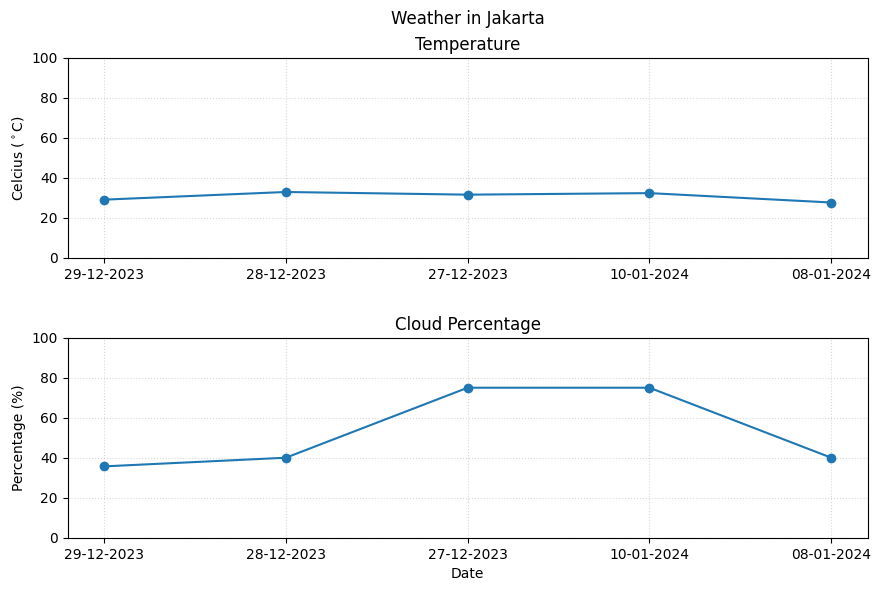

In [12]:
print('Visualizing Data.')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)
fig.suptitle(f'Weather in {Filter_City}')

# Sorting Data
Filtered_Date = Filtered_Date.sort_values(by='Date', ascending=False).reset_index(drop=True)

# Define data to plotting
ax1.plot(Filtered_Date['Date'],
        Filtered_Date['Temp_Avg'], 'o-')

ax2.plot(Filtered_Date['Date'],
        Filtered_Date['Cloud'], 'o-')

# Configure the label and title figure
ax1.set(ylabel=r'Celcius ($^\circ$C)',
       )
ax1.set_title('Temperature')

ax2.set(xlabel='Date',
       ylabel=r'Percentage (%)',
       )
ax2.set_title('Cloud Percentage')

# Configure grid to visualize the y axis grid
ax1.grid(which='both')
ax1.grid(which='minor', alpha=0.2, linestyle='dotted')
ax1.grid(which='major', alpha=0.5, linestyle='dotted')
ax1.set_ylim([0, 100])

ax2.grid(which='both')
ax2.grid(which='minor', alpha=0.2, linestyle='dotted')
ax2.grid(which='major', alpha=0.5, linestyle='dotted')
ax2.set_ylim([0, 100])
print('Done.')

plt.show()